In [ ]:
!pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Sequential
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model, load_model

%matplotlib inline




In [ ]:
train_dir = 'C:/Users/ozcan/Desktop/images/train'

# Create an instance of ImageDataGenerator with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Rescale pixel values from [0, 255] to [0, 1]
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Use 20% of the data for validation
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation'
)



Found 23060 images belonging to 7 classes.
Found 5761 images belonging to 7 classes.


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=1,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training',
    shuffle=True
)

class_indices = {v: k for k, v in train_generator.class_indices.items()}
print("Class indices:", class_indices)

Found 23060 images belonging to 7 classes.
Class indices: {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


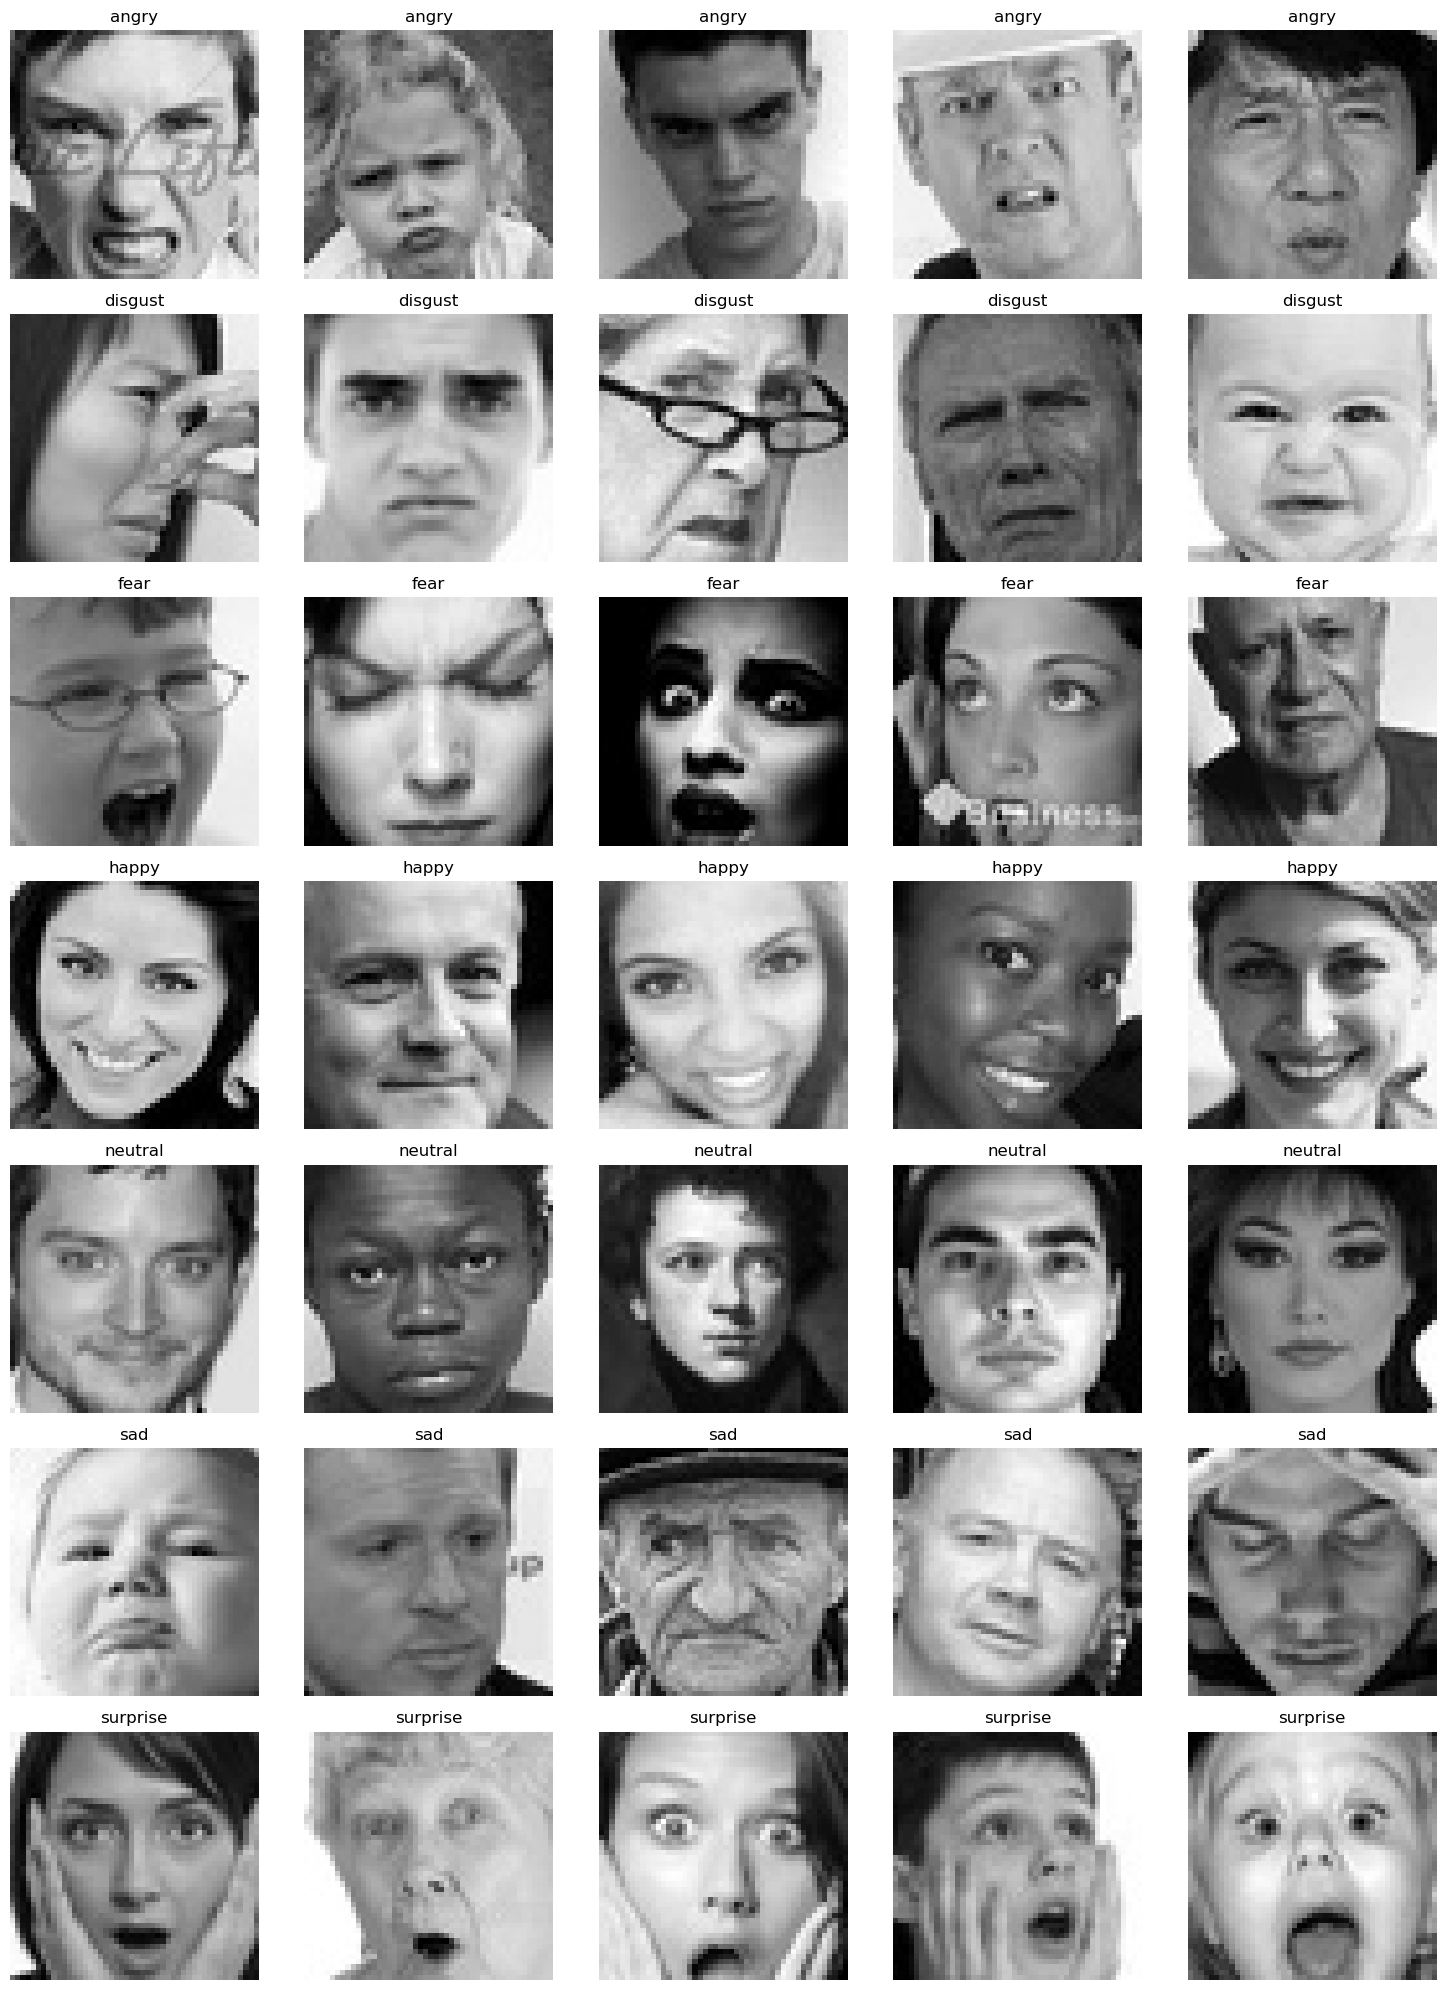

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

images_per_class = {class_name: 0 for class_name in class_indices.values()}

fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(15, 20))

for images, labels in train_generator:
    for i in range(len(labels)):
        label_index = np.argmax(labels[i])
        class_name = class_indices[label_index]

        if images_per_class[class_name] < 5:
            ax = axes[label_index, images_per_class[class_name]]
            ax.imshow(images[i].reshape(48, 48), cmap='gray')
            ax.set_title(class_name)
            ax.axis('off')

            images_per_class[class_name] += 1

        if all(count >= 5 for count in images_per_class.values()):
            break

    if all(count >= 5 for count in images_per_class.values()):
        break

plt.tight_layout()
plt.show()



In [ ]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

Emotion angry: 3195 samples
Emotion disgust: 349 samples
Emotion fear: 3283 samples
Emotion happy: 5732 samples
Emotion neutral: 3986 samples
Emotion sad: 3951 samples
Emotion surprise: 2564 samples


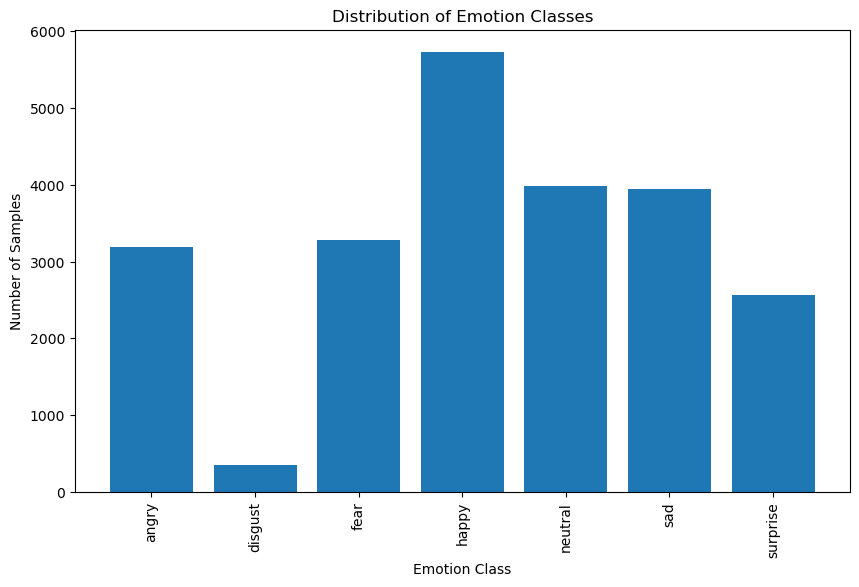

In [ ]:
class_counts = train_generator.classes
class_labels = list(class_indices.values())
class_indices_reversed = {v: k for k, v in class_indices.items()}
class_counts_per_class = [np.sum(class_counts == class_indices_reversed[label]) for label in class_labels]

plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_counts_per_class)
plt.xlabel('Emotion Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of Emotion Classes')
plt.xticks(rotation='vertical')

for label, count in zip(class_labels, class_counts_per_class):
    print(f"Emotion {label}: {count} samples")

plt.show()


In [ ]:
image_list = []
label_list = []

for _ in range(10):
    images, labels = next(train_generator)
    image_list.append(images)
    label_list.append(labels)

image_array = np.vstack(image_list)
image_label = np.vstack(label_list)

image_array = image_array / 255.0

image_label = np.argmax(image_label, axis=1)

X_train, X_val, y_train, y_val = train_test_split(image_array, image_label, test_size=0.2, random_state=42)


In [ ]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.regularizers import l2

def ensure_three_channel(image):
    if image.shape[-1] == 1:
        return np.repeat(image, 3, axis=-1)
    elif image.shape[-1] == 3:
        return image
    else:
        raise ValueError(f"Unexpected image shape: {image.shape}")

# Adding the channel dimension to the input images
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

class_distribution = {
    0: 3995,
    1: 436,
    2: 4097,
    3: 7215,
    4: 4830,
    5: 3171,
    6: 4965
}

augmentation_factors = {
    0: 3.0,
    1: 10.0,
    2: 2.0,
    3: 1.0,
    4: 1.5,
    5: 5.0,
    6: 1.0
}

max_factor = max(augmentation_factors.values())
class_weights = {
    class_label: max_factor / augmentation_factors[class_label]
    for class_label in class_distribution.keys()
}

data_augmenter = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

desired_augmentation_counts = {
    class_label: int(class_distribution[class_label] * factor / 10)  # Reduce number of augmentations temporarily
    for class_label, factor in augmentation_factors.items()
}

augmented_X_train = []
augmented_y_train = []

start_time = time.time()

for class_label in class_distribution.keys():
    class_indices = np.where(y_train == class_label)[0]

    if len(class_indices) == 0:
        continue

    num_augmentations = desired_augmentation_counts[class_label]

    for _ in range(num_augmentations):
        random_index = np.random.choice(class_indices)
        original_image = X_train[random_index]

        try:
            original_image = ensure_three_channel(original_image)
            original_image = np.squeeze(original_image)  # Remove any singleton dimensions
            print(f"Original Image Shape: {original_image.shape}")

            augmented_image = data_augmenter.random_transform(original_image)
            print(f"Augmented Image Shape: {augmented_image.shape}")

            augmented_image = augmented_image[..., :1]  # Ensure it's single-channel for grayscale

            augmented_X_train.append(augmented_image)
            augmented_y_train.append(class_label)
        except ValueError as e:
            print(f"Error processing image: {e}")
            continue

end_time = time.time()
print(f"Data augmentation completed in {end_time - start_time} seconds")

augmented_X_train = np.array(augmented_X_train)
augmented_y_train = np.array(augmented_y_train)

augmented_X_train = augmented_X_train.reshape(-1, 48, 48, 1)

shuffled_indices = np.random.permutation(len(augmented_X_train))
augmented_X_train = augmented_X_train[shuffled_indices]
augmented_y_train = augmented_y_train[shuffled_indices]

X_val = X_val.reshape(-1, 48, 48, 1)

model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(5, 5), padding='same', name='image_array', input_shape=(48, 48, 1)))
model.add(Conv2D(filters=64, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(.3))

model.add(Conv2D(filters=96, kernel_size=(5, 5), padding='same'))
model.add(Conv2D(filters=96, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(.3))

model.add(Conv2D(filters=128, kernel_size=(5, 5), padding='same'))
model.add(Conv2D(filters=128, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(.3))

model.add(Conv2D(filters=256, kernel_size=(5, 5), padding='same'))
model.add(Conv2D(filters=256, kernel_size=(5, 5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())

model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256, kernel_regularizer=l2(0.01)))  # L2 reg
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

# Fully connected layer 2nd layer
model.add(Dense(512, kernel_regularizer=l2(0.01)))  # L2 reg
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(7, activation='sigmoid'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cb_early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.0005,
    patience=11,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

cb_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.5,
    patience=10,
    verbose=1,
    mode="auto",
    min_lr=1e-7,
)

cb_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_model.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

history = model.fit(
    augmented_X_train, augmented_y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=[cb_early_stop, cb_reduce_lr, cb_model_checkpoint]
)


Original Image Shape: (48, 48, 3)
Augmented Image Shape: (48, 48, 3)
Original Image Shape: (48, 48, 3)
Augmented Image Shape: (48, 48, 3)
Original Image Shape: (48, 48, 3)
Augmented Image Shape: (48, 48, 3)
Original Image Shape: (48, 48, 3)
Augmented Image Shape: (48, 48, 3)
Original Image Shape: (48, 48, 3)
Augmented Image Shape: (48, 48, 3)
Original Image Shape: (48, 48, 3)
Augmented Image Shape: (48, 48, 3)
Original Image Shape: (48, 48, 3)
Augmented Image Shape: (48, 48, 3)
Original Image Shape: (48, 48, 3)
Augmented Image Shape: (48, 48, 3)
Original Image Shape: (48, 48, 3)
Augmented Image Shape: (48, 48, 3)
Original Image Shape: (48, 48, 3)
Augmented Image Shape: (48, 48, 3)
Original Image Shape: (48, 48, 3)
Augmented Image Shape: (48, 48, 3)
Original Image Shape: (48, 48, 3)
Augmented Image Shape: (48, 48, 3)
Original Image Shape: (48, 48, 3)
Augmented Image Shape: (48, 48, 3)
Original Image Shape: (48, 48, 3)
Augmented Image Shape: (48, 48, 3)
Original Image Shape: (48, 48, 3)


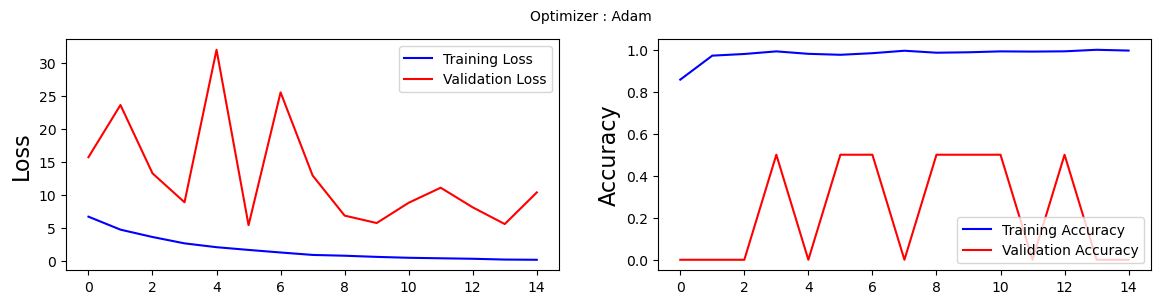

In [ ]:
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], color='b', label='Training Loss')
plt.plot(history.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], color='b', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
import shutil
import os
import random

validation_dir = 'C:/Users/ozcan/Desktop/images/validation'
test_dir = 'C:/Users/ozcan/Desktop/images/test'

if not os.path.exists(test_dir):
    os.makedirs(test_dir)
    for class_name in os.listdir(validation_dir):
        os.makedirs(os.path.join(test_dir, class_name))

# Move a portion of validation data to test directory
test_split_ratio = 0.2  # 20% of validation data for testing

for class_name in os.listdir(validation_dir):
    class_dir = os.path.join(validation_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)

    images = os.listdir(class_dir)
    random.shuffle(images)
    split_idx = int(len(images) * test_split_ratio)

    for image in images[:split_idx]:
        src = os.path.join(class_dir, image)
        dst = os.path.join(test_class_dir, image)
        try:
            shutil.move(src, dst)
        except FileNotFoundError:
            os.makedirs(test_class_dir, exist_ok=True)
            shutil.move(src, dst)
        except Exception as e:
            print(f"Error moving file {src} to {dst}: {e}")
print("Validation and Test folders created successfully.")

# Create an instance of ImageDataGenerator for test data
test_datagen = ImageDataGenerator(rescale=1.0/255.0)  # Rescale pixel values from [0, 255] to [0, 1]

# Create the test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    batch_size=32,
    class_mode=None,
    color_mode='grayscale',
    shuffle=False
)


Validation and Test folders created successfully.
Found 4740 images belonging to 7 classes.


In [ ]:
filename = "best_model.keras"
filepath = os.path.abspath(filename)

model = load_model(filepath)

y_test_pred = model.predict(test_generator, verbose=1)

y_test_pred_labels = np.argmax(y_test_pred, axis=1)


filenames = test_generator.filenames
submission_df = pd.DataFrame({'filename': filenames, 'emotion': y_test_pred_labels})

submission_df.to_csv('submission.csv', index=False)

y_pred = model.predict(validation_generator, verbose=1)
y_pred_labels = np.argmax(y_pred, axis=1)

f1_scores = f1_score(validation_generator.classes, y_pred_labels, average=None)

weighted_f1 = f1_score(validation_generator.classes, y_pred_labels, average='weighted')

for i in range(7):
    class_name = emotions[i]
    print(f"'{class_name}' F1 Score: {f1_scores[i]:.4f}")

print("Weighted F1 Score:", weighted_f1)

conf_matrix = confusion_matrix(validation_generator.classes, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=emotions.values(), yticklabels=emotions.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

fig, axs = plt.subplots(10, 5, figsize=(12, 20))
fig.subplots_adjust(hspace=.5)

for i in range(50):
    ax = axs[i // 5, i % 5]
    img = plt.imread(os.path.join(test_dir, filenames[i]))
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Predicted: {emotions[y_test_pred_labels[i]]}')
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.show()



In [ ]:
pip install opencv-python

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

filename = "best_model.keras"
filepath = os.path.abspath(filename)
model = load_model(filepath)

emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

cap = cv2.VideoCapture(0)

def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (48, 48))
    normalized = resized / 255.0
    reshaped = np.reshape(normalized, (1, 48, 48, 1))
    return reshaped

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    if not ret:
        break
    preprocessed_frame = preprocess_image(frame)
    predictions = model.predict(preprocessed_frame)
    emotion_label = np.argmax(predictions)
    emotion_text = emotions[emotion_label]

    cv2.putText(frame, emotion_text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
    cv2.imshow('Real-time Facial Expression Recognition', frame)

    # Break the loop on 'q' key pqress
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the capture and close windows
cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━

KeyboardInterrupt: 